In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
train2013twitter = pd.read_csv('twitter-2013train-A.tsv', delimiter = '\t', header = None)
train2015twitter = pd.read_csv('twitter-2015train-A.tsv', delimiter = '\t', header = None)
train2016twitter = pd.read_csv('twitter-2016train-A.tsv', delimiter = '\t', header = None)
train_dev2016 = pd.read_csv('twitter-2016dev-A.tsv', delimiter = '\t', header = None)
test_dev2016 = pd.read_csv('twitter-2016devtest-A.tsv', delimiter = '\t', header = None)
test2016twitter = pd.read_csv('twitter-2016test-A.tsv', delimiter = '\t', header = None)

In [0]:
train_model = train2013twitter.append(train2015twitter).append(train2016twitter).append(train_dev2016)
test_model = test2016twitter.append(test_dev2016)

In [0]:
train_model.columns = ['id', 'label', 'tweets']
test_model.columns = ['id', 'label', 'tweets']

In [0]:
#message 'Not Available' removed
train_model = train_model[~train_model['tweets'].isin(['Not Available'])]
test_model = test_model[~test_model['tweets'].isin(['Not Available'])]

In [0]:
#length of tweets
train_model['pre_clean_len'] = [len(t) for t in train_model.tweets]
test_model['pre_clean_len'] = [len(t) for t in test_model.tweets]

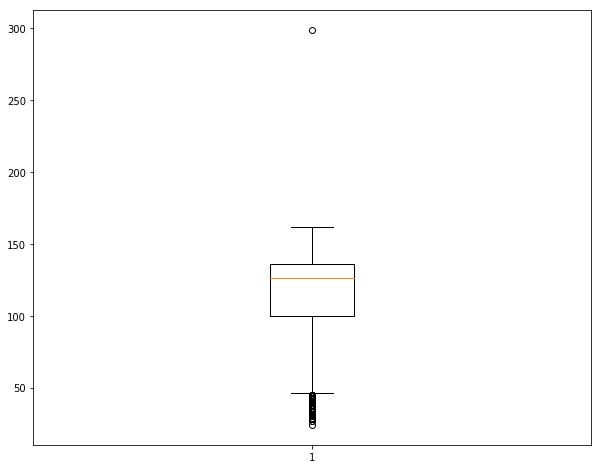

In [0]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.boxplot(train_model.pre_clean_len)
plt.show()

In [0]:
train_model[train_model.pre_clean_len > 140].head(10)

,id,label,tweets,pre_clean_len
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding...",144
21,263975113404342273,neutral,Expect light-moderate rains over E. Visayas; C...,144
36,257951107530252289,negative,@MelmurMel @PBandJenelley_1 @vl_delp_ham_ Jene...,143
65,263797084673691648,neutral,@lala_cox There are going to be plenty of ups ...,144
86,259452211883569152,neutral,JACKALS GOAL! Jimmy Martin sneaks a rebound pa...,142
134,240553933116944384,positive,@RediTlhabi @StevenB7777 OCTOBER people have ...,147
147,258989036205662208,neutral,"When I teach a basketball in my own school, we...",142
148,264084748345962496,neutral,AT&amp;T offers free cloud storage for iOS and...,151
178,263953741877764096,neutral,Snow may fall for parts of CNY the next few da...,141
217,263098506644955136,neutral,##$$## Black Friday Deals Nikon D3200 24.2 Meg...,144


In [0]:
test_model[test_model.pre_clean_len > 140].head(10)

,id,label,tweets,pre_clean_len
74,620402199240151040,negative,The Asian girls in the swim suit section for M...,141
103,620449026186575872,neutral,"#TeamFollowBack Another pageant, another Q&amp...",141
107,620456013582368768,neutral,.@TheRealKamie I'm the 1st to say embrace your...,142
110,620467935174209536,neutral,Instead of watching the Miss USA pageant I wat...,144
187,620694757447176192,neutral,"Sunday, during the Q&amp;A segment of the Miss...",142
199,620718775877419012,positive,Whoa! National Ice Cream Day is in six days?! ...,144
266,621066477576306690,positive,Sunday is National Ice Cream Day! We will ha...,142
306,621307763168268289,neutral,"So George Osborne, Therera May &amp; Yvette Co...",144
308,621326803148259329,positive,@BaekDoXiuHun Hi! My bias is KAI bc he stole m...,143
427,622119071186874368,positive,Sunday is National Ice Cream Day! Get your fav...,142


In [0]:
#html decoding
train_model['tweets'] = train_model['tweets'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
test_model['tweets'] = test_model['tweets'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [0]:
#length of tweets
train_model['pre_clean_len'] = [len(t) for t in train_model.tweets]
test_model['pre_clean_len'] = [len(t) for t in test_model.tweets]

In [0]:
#reindex
train_model = train_model.reset_index(drop=True)
test_model = test_model.reset_index(drop=True)

In [0]:
def get_size(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)
model_pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text', Pipeline([
                ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
            ])),
            ('length', Pipeline([
                ('count', FunctionTransformer(get_size, validate=False)),
            ]))
        ])),
        ('classifier', MultinomialNB())
    ])



model_pipeline.fit(train_model.tweets, train_model.label)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1...nsformer_weights=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [0]:
predict = model_pipeline.predict(test_model.tweets)
#accuracy
np.mean(predict == test_model.label)

0.571079997676175

In [0]:
from textblob import TextBlob
polarities=[]
for i in range(test_model.tweets.count()):
    testimonial = TextBlob(test_model.tweets.iloc[i])
    polarities.append(testimonial.sentiment.polarity)

new_label=[]
for i in range(test_model.tweets.count()):
    if polarities[i] > 0.3:
        new_label.append('positive')
    elif polarities[i] < -0.3:
        new_label.append('negative')
    else:
        new_label.append('neutral')
#accuracy       
np.mean(new_label == test_model.label)

0.5607970719804799

In the test2016 dataset when I was reading through pandas, python returns me an error. So I open the dataset via Libreoffice and I notice that on some rows there was a timestamp. Thus, I delete those timestamps and I continue the process. I plot the pre_clean_len (length of each tweet) so that I can see the overall distribution of lenght of strings in each entry and I notice that some tweets are away more than 140 characters long (the twitter's character limit is 140). So it looks like HTML encoding has not been converted to text, and ended up in text field as '&amp' so I decoding HTML to general text for the first step of data cleaning. I used a pipeline which is a set of chained algorithm to extract features, preprocess them and then train. Also, I used tf-idf and CountVectorizer as feature extraction and then classified these using Naive Bayes.